In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.test import TestModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_test
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode_osc
import scipy

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'
fs_=16
plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams["axes.titlesize"] = fs_
matplotlib.rc('xtick', labelsize=fs_) 
matplotlib.rc('ytick', labelsize=fs_) 
plt.rc('legend',fontsize=fs_)

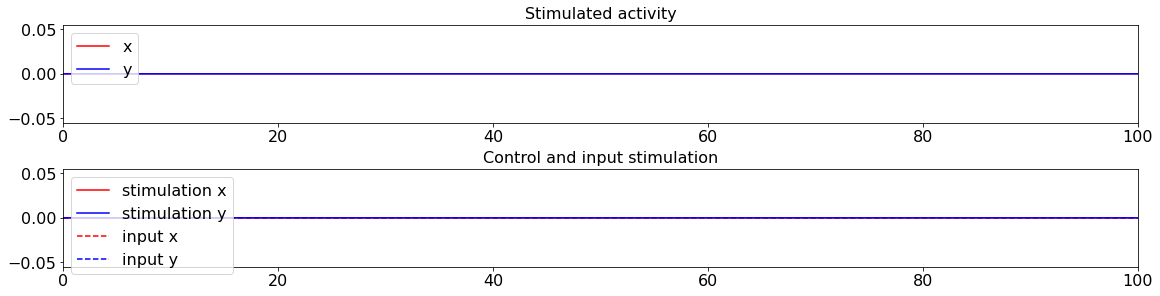

In [2]:
test = TestModel()
test.params.sigma_ou = 0.
test.params.x_ou_mean = 0.

dt = 0.01
test.params.dt = dt

duration = 100.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
input = zero_control.copy()

test.params["duration"] = duration
x_init = 0.
y_init = 0.
test.params["xs_init"] = np.array([[x_init]])
test.params["ys_init"] = np.array([[y_init]])

test.params["x_ext"] = zero_input
test.params["y_ext"] = zero_input

test.run()

state = np.concatenate((np.concatenate( (test.params["xs_init"], test.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (test.x, test.y), axis=1)), axis=2)

plot_oc_singlenode_osc(duration, dt, state, zero_control, orig_input=zero_control)

In [3]:
def dxf(x, w_phase, ind_tau):

    result = np.zeros((x.shape-ind_tau))
    result_tau = result.copy()
    result_total = result.copy()
    p = result.copy()
    p_tau = result.copy()
    cost = result.copy()

    x_analytic = scipy.signal.hilbert(x[:-ind_tau])
    y_ = x_analytic.imag
    x_ = x[:-ind_tau]
    x_analytic_tau = scipy.signal.hilbert(x[ind_tau:])
    y_tau = x_analytic_tau.imag
    x_tau = x[ind_tau:]
    for t in range(len(result)):
        p[t] = np.arctan2(y_[t], x_[t])
        p_tau[t] = np.arctan2(y_tau[t], x_tau[t])
        factor = - 2. * w_phase * (np.cos(p[t])*np.sin(p_tau[t]) - np.sin(p[t])*np.cos(p_tau[t]))
        result[t] = -y_[t]/ (x_[t]**2 + y_[t]**2)
        result_tau[t] = -y_tau[t]/ (x_tau[t]**2 + y_tau[t]**2)
        result[t] *=factor
        result_tau[t] *= -factor

    result_total = result + result_tau

    cost = -w_phase * ( (np.cos(p) + np.cos(p_tau))**2 + (np.sin(p) + np.sin(p_tau))**2 )

    cost_functions.check_phase_variation(cost, p, ind_tau, dt)

    print("cost")
    plt.plot(cost)
    plt.show()

    print("derivative")
    plt.plot(result_total)
    plt.show()

    print("phase, phase tau")
    plt.plot(p, label='phi')
    plt.plot(p_tau, label='phi_tau')
    plt.legend()
    plt.show()

    print("x, y, tau")
    plt.plot(x_, label='x')
    plt.plot(y_, label='y')
    plt.plot(x_tau, label='x_tau')
    plt.plot(y_tau, label='y tau')
    plt.legend()
    plt.show()



    return result_total, result, result_tau

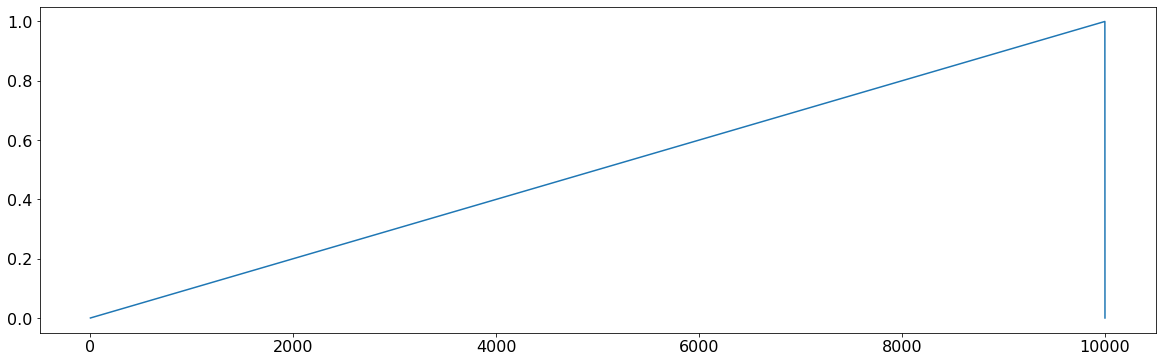

In [17]:
period = 10.
input_period = 200.

control_mat = np.zeros( (test.params.N, len(test.state_vars)) )
control_mat[0,0] = 1.

prec_mat = np.zeros( (test.params.N, len(test.output_vars)) )
prec_mat[0,0] = 1.

w2 = 1.
int0 = 0 #zero_input.shape[1] - np.round(.*period/dt).astype(int)

input1 = zero_control.copy()

in_start0 = 0
in_dur0 = min(duration-in_start0, 100)

#input1[0,0,np.round(in_start0/dt).astype(int):np.round((in_start0+in_dur0)/dt).astype(int)] = 1e-2 * (np.sin(2. * np.pi * np.arange(in_start0,in_start0+in_dur0,dt)/input_period))
input1[0,0,np.round(in_start0/dt).astype(int):np.round((in_start0+in_dur0)/dt).astype(int)] = 1e-2 * (np.arange(in_start0,in_start0+in_dur0,dt))

in_start1 = 60
in_dur1 = min(duration-in_start1, 40)

#input1[0,0,np.round(in_start1/dt).astype(int):np.round((in_start1+in_dur1)/dt).astype(int)] = 2. * (np.sin(2. * np.pi * np.arange(in_start1,in_start1 + in_dur1,dt)/input_period))

plt.plot(input1[0,0,:])
plt.show()

Compute control for a deterministic system
Cost in iteration 0: 10.698162949716357
Final cost : 10.698162949716357


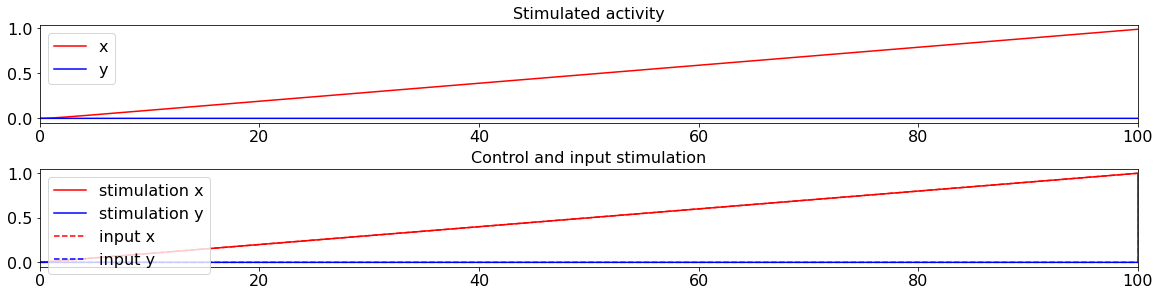

TypeError: 'NoneType' object is not subscriptable

In [18]:
test.params["x_ext"] = input1[:,0,:]
test.params["y_ext"] = zero_input

int0, int1 = 0,10000

test_controlled = oc_test.OcTest(test, w_p=0, w_ac=1, target_period=period, w_2=w2, print_array=np.arange(0,1001,10), cost_interval=(int0,int1), control_matrix=control_mat, precision_matrix=prec_mat)
test_controlled.step = 1e0

test_controlled.optimize(0)

state = test_controlled.get_xs()
control = test_controlled.control

plot_oc_singlenode_osc(duration, dt, state, control, orig_input=input1)

grad = test_controlled.grad
plt.plot(grad[0,0,:])
plt.show()

In [95]:
int0 = 6000
int1 = 8000
test_controlled.step = 1e-2

if False:
    control0 = test_controlled.control.copy()
    control0[0,0,int1-1000:] +=0.2
    test_controlled.control = control0
    test_controlled.update_input()

In [96]:

print(int0, int1)
#print("min cost ", 4.*((int1-int0)*dt))
test_controlled.cost_interval = (int0, int1)
test_controlled.zero_step_encountered = False

test_controlled.optimize(400)

plotstate()

6000 8000
Compute control for a deterministic system


AttributeError: 'OcTest' object has no attribute 'precision_cost_interval'

In [7]:
def plotstate():
    state = test_controlled.get_xs()
    control = test_controlled.control
    plot_oc_singlenode_osc(duration, dt, state, control, orig_input=input1)

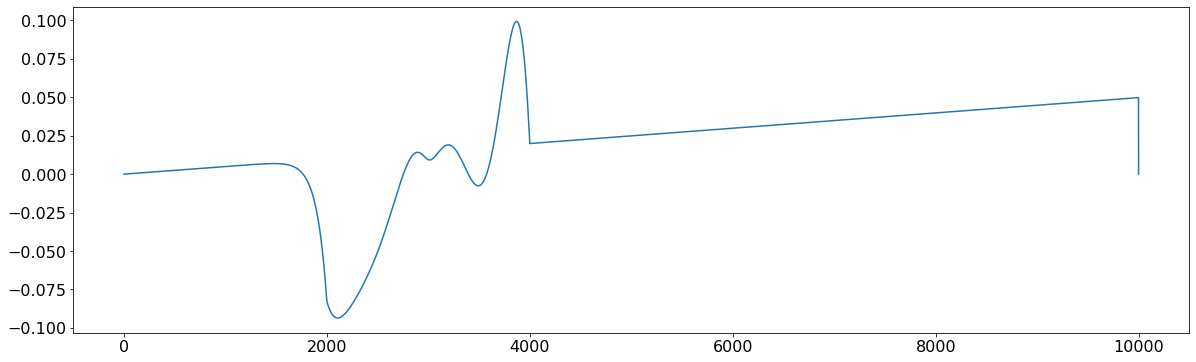

In [33]:
grad = test_controlled.grad
plt.plot(grad[0,0,:])
plt.show()

cost


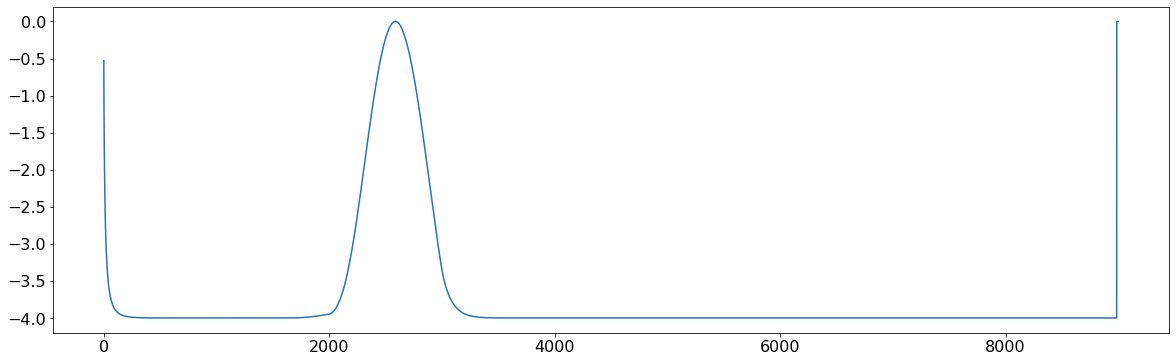

derivative


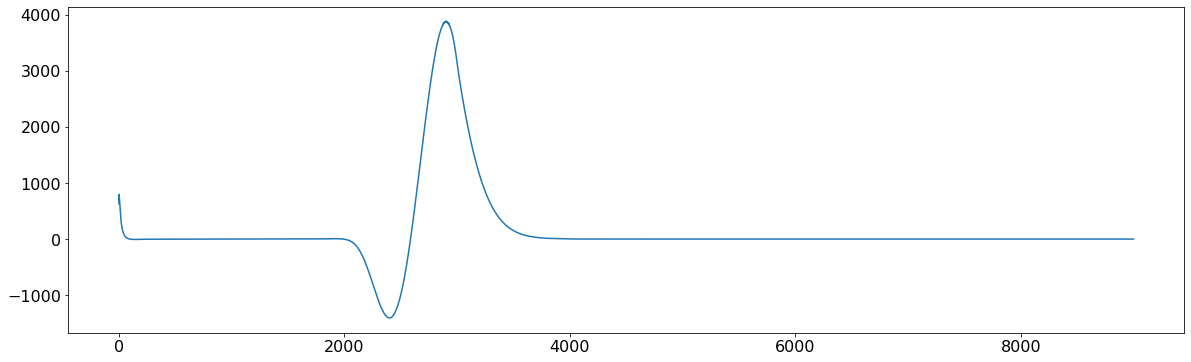

phase, phase tau


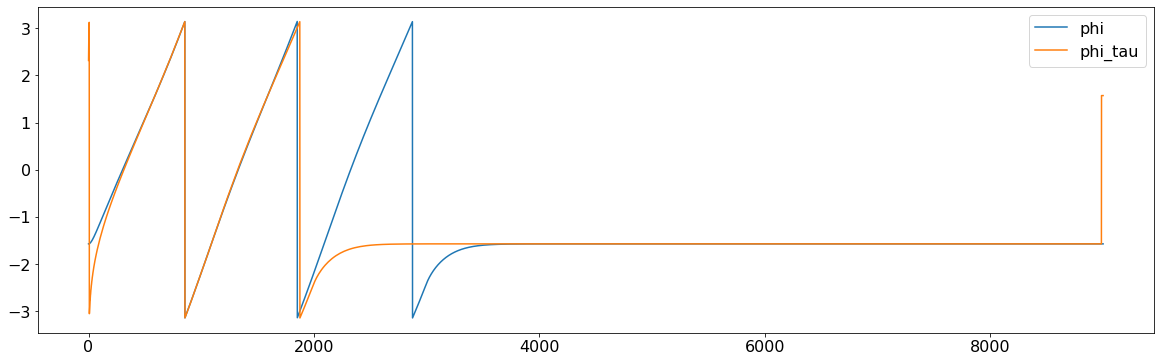

x, y, tau


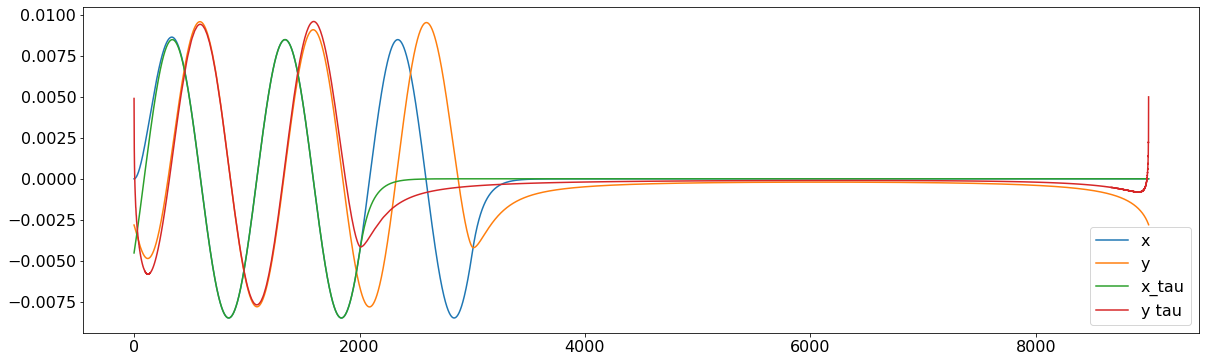

In [176]:
der, der_t, der_tau = dxf(state[0,0,:], 1., np.round(period/dt).astype(int))